# STEP 0 : Load data

## Dog datasets

Populate variables relative to the training, validation and test set using load_file function from sklearn
train_files, valid_files, test_files contain the images
train_labels, valid_lables, test_labels contains the labels

In [1]:
from sklearn.datasets import load_files
import numpy as np
from keras.utils import np_utils

# create a function to load variables and labels using load file
def load_datasets(path):
    data = load_files(path)
    X = np.array(data['filenames'])
    Y = np_utils.to_categorical(np.array(data['target']))
    return X, Y

# load training, validation and test sets
train_files, train_labels = load_datasets('dog_data/train')
valid_files, valid_labels = load_datasets('dog_data/valid')
test_files, test_lables = load_datasets('dog_data/test')

Using TensorFlow backend.


In [2]:
# save dog breeds names in a folder for labels matching
from glob import glob

dog_breeds_names = []
dog_breeds_folders = sorted(glob('dog_data/train/*'))
for folder in dog_breeds_folders:
    dog_breeds_names.append(folder[15:-1])

In [3]:
# display some information relative to datasets size
print('Dog training set has', len(train_files), 'data points (dog images)')
print('Dog validation set has', len(valid_files), 'data points (dog images)')
print('Dog test set has', len(test_files), 'data points (dog images)')
print('Data is using', len(dog_breeds_names), 'different breeds')

Dog training set has 6680 data points (dog images)
Dog validation set has 835 data points (dog images)
Dog test set has 836 data points (dog images)
Data is using 133 different breeds


## Human datasets

We will also ask the app to predict a dog breed for human images. 
The learning algorithm will not be trained on the human dataset. However, the app needs a valid image i.e. a human face, hence the use of an algorithm to decect the presence or not of a human face on the image fed by the user to the dog breeds dectection app.

In [4]:
import random
random.seed(42)

# load human dataset and shuffle it
human_files = glob('human_data/*/*')
random.shuffle(human_files)

# display some infomation about human dataset
print('Human dataset contains', len(human_files), 'data points (human images)')

Human dataset contains 13233 data points (human images)


# STEP 1 : Detect humans

We will use a pre-trained face detector from OpenCV that implements [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html).
The face detector is stored as an xml file under the folder ./haarcascades.

number of faces detected: 1


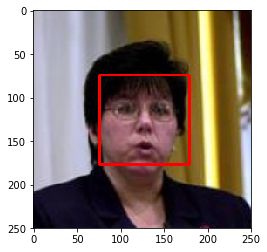

In [6]:
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline

# import classifier and input image in greyscale mode
face_detector = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread(human_files[0])
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# detect faces 
faces = face_detector.detectMultiScale(gray_img)

# display number of detected faces
print('number of faces detected:', len(faces))

image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# highlith the detected faces with a square
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(image_rgb,(x,y),(x+w,y+h),(255,0,0),2)
    
# display image and detected faces
plt.imshow(image_rgb)
plt.show()


In [7]:
# return True if at least one face is detected
def faces_detected(path):
    img = cv2.imread(path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_image)
    return len(faces) != 0

We will now assess the accuracy of face_detector classifier using the first 100 data points from human dataset and dog dataset.

In [8]:
# build dog and human datasets with 100 images each 
small_human_dataset = human_files[:99]
small_dog_dataset = train_files[:99]

true_positive = 0
false_positive = 0

for human_image in small_human_dataset:
    if faces_detected(human_image) == True:
        true_positive += 1

for dog_image in small_dog_dataset:
    if faces_detected(dog_image) == True:
        false_positive += 1
    
print('face_detector detected', true_positive, '% of faces in human dataset and detected', false_positive, '% of the dog dataset as human faces')

face_detector detected 96 % of faces in human dataset and detected 11 % of the dog dataset as human faces


# STEP 2 : Detect dogs

## Import a pre-trained Deep Learning model

We use [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) for detect dogs in images. We use it with weights pre-trained on ImageNet. ImageNet is a vey large dataset used for image classification. It contains over 10 million URLs. Each URL links to an image from [1000 classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).
This model can be used to detect the presence of an object belonging to one of the 1000 different categories available in ImageNet. 

In [9]:
# Keras Applications are deep learning models that are made available alongside pre-trained weights.
from keras.applications.resnet50 import ResNet50

# download ResNet50 with weights pre-trained on ImageNet
ResNet50_model = ResNet50(weights='imagenet')

## Data preprocessing

When used with Tensorflow, Keras CNN need 4D tensors as inputs in the form of **(nb_samples, nb_rows, nb_columns, nb_channel)** :

- nb_samples : number of data points in the dataset
- nb_rows : the height of the image
- nb_columns : the width of the image
- nb_channels : the depth of the image (1 if it is in grey scale and 3 in RGB for exemple)

We need to transform the input images into 4D tensors in order to feed them to our ResNet50_model.

In [13]:
from keras.preprocessing import image
#from tqdm import tqdm


# retun a 4D tensor in the shape (1, 224, 224, 3) from image path
def path_to_tensor(path):
    # load the image as PIL.Image.Image and resize it to a 224*224
    img = image.load_img(path, target_size=(224, 224))
    # convert PIL.Image.Image to a 3D tensor (shape (224, 224, 3))
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return it
    return np.expand_dims(x, axis=0)

# return a 4D tensor in the shape (nb_samples, 224, 224, 3) from paths of images
def paths_to_tensor(paths):
    # create a list of 3D tensors
    tensors = []
    for path in paths:
        tensors.append(path_to_tensor(path))
    # return a 4D tensor in the shape (len(paths), 224, 224, 3)
    return np.vstack(tensors)
        

## Make predictions with ResNet-50

Before making predictions with ResNet-50 model, the 4D tensors need futher processing:
- transform RGB to BGR by reordering channels
- normalize the pixels by soustracting the mean value for each channel 
preprocess_input module from keras.applications.resnet50 can perfome these tasks.

The prediction is permofmed by the `predict` method which outputs a probability vector. The element number **$i$** from this vector corresponds to the probabilty that the input image is the object number **$i$** from the ImageNet data set. We use `argmax` to find the number correponding to the object with the highest probability. 

In [14]:
from keras.applications.resnet50 import preprocess_input 

def resnet50_prediction(path):
    # transform from RBG to BGR and normalize the pixels values
    img = preprocess_input(path_to_tensor(path))
    # return the max value corresponding to the predicted object
    return np.argmax(ResNet50_model.predict(img))
    

In [15]:
img_path = train_files[0]
img = preprocess_input(path_to_tensor(img_path))
np.argmax(ResNet50_model.predict(img))

222

## Detect dogs with ResNet-50

Looking at the ResNet-50 [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we find that the entries from 151 to 268 corresponds to different kinds of dogs (from `'Chihuahua'` to `'Mexican hairless'`. 
To detect a dog, we have to check if the preficted number is betwen 151 and 286 (inclusively). 

In [16]:
def dog_detected(path):
    return resnet50_prediction(path) in range(151,269)

In [185]:
def dog_detector(img_path):
    prediction = resnet50_prediction(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

We will now assess the accuracy of the dog detector on the small human data set and the small dog dataset.

In [18]:
accuracy_human = 0
accuracy_dog = 0

for img in small_human_dataset:
    if dog_detected(img) == True:
        accuracy_human += 1
for img in small_dog_dataset:
    if dog_detected(img) == True:
        accuracy_dog += 1

print(accuracy_human, "% of human images with a detected dog and ", accuracy_dog, "% of dog images with a detected dog dog")

1 % of human images with a detected dog and  99 % of dog images with a detected dog dog


# STEP 3 : Create a CNN to detect a dog breed from scratch

## Preprocess data

In [20]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

## Create a CNN for breed detection

### Define the CNN architecture

In [29]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())
model.add(Dense(len(dog_breeds_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 64)                0         
__________

### Compile the CNN model

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the CNN model

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
num_epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_labels,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(valid_tensors, valid_labels),
          callbacks=[checkpointer])

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6656/6680 [============================>.] - ETA: 0s - loss: 4.8842 - acc: 0.0081